In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import sys
#import os
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('../data/us_CID_activity_2014_2017.csv') # Read the data

In [3]:
#df.head() # Take a quick look

In [4]:
df.shape # Check out the size

(887709, 52)

In [5]:
#df.columns # Check out the columns

In [6]:
df.Country.unique() # Given that this is the US data, the NaNs are USA as well

array(['USA', nan], dtype=object)

In [7]:
df.Currency.unique() # Given that this is the US data, the NaNs are USD as well

array(['USD', nan], dtype=object)

In [8]:
df.Channel.unique() # Need to figure out what to do with NaNs

array(['Partner', 'DirectLocal', 'National', 'Deals', nan], dtype=object)

In [9]:
df.drop(columns=['Country', 'Currency', 'Advertiser_URL'], axis=1, inplace=True) # Useless data in this context
df.reset_index(inplace=True,drop=True)

In [10]:
#df.dtypes # Check the data types

In [11]:
df.TargetType.unique() # What's this column?

array(['Radius', 'Country', 'Metro', 'City', 'PostCode'], dtype=object)

In [12]:
#df.describe().T # Let's get a feel for the data --> There are campaign budgets equal to zero!

In [13]:
# Drop the "unnecessary" columns (for now)

df.drop(columns=['BC_ID','BusinessCategory', 'Primary_BSC_ID', 'Primary_BusinessSubCategory',
                'Secondary_BSC_Count','Secondary_BSC_IDs','Seconardy_BSCs','BusinessSpecialtyID',
                'BusinessSpecialty'], axis=1, inplace=True)
df.reset_index(inplace=True,drop=True)

## Let's look at the fishy stuff.

In [14]:
# CPL an CTL have exactly the same number of missing values. Check and see if this is because of the 
# product type.

# Check to see if they're are missing at the exact same locations:

print( (((np.isnan(df.CTL)) & (np.isnan(df.CPL))).sum()) == df.CTL.isna().sum() )

temp=df[['idadvertiser_master', 'idOffer', 'Offer_Name','CPL', 'CTL']]

temp[np.isnan(temp.CTL)]['idadvertiser_master'].nunique()


True


18545

In [15]:
df.idadvertiser_master.nunique()

38042

In [16]:
# Quite a lot of the data is missing from CPL and CLT. For about half of the 
# advertisers, this data is missing. Check what they are. For the time 
# being let's drop them. Same thing with CPC and CTR

In [17]:
df.drop(columns=['CTL', 'CPL','CPC', 'CTR'], axis=1, inplace=True)
df.reset_index(inplace=True,drop=True)

In [18]:
#df.isna().sum()

In [19]:
# Dealing with Offer, Finance Product, idOffer (There are only a few of them?)

missing_offer_ids=df[df.Offer_Name.isna()]['idadvertiser_master'].unique()

# Check to see if their are missing at the exact same locations:

df=df[~df.idadvertiser_master.isin(missing_offer_ids)]
df.reset_index(inplace=True,drop=True)

In [20]:
#df.isna().sum()

In [21]:
# Create a duration column. For missing values, one option is to replace with the average 
# campaign duration of a given advertiser--> Local!
# However we're not sure why the cycle is missing an end date. Is that churn?
df['Cycle_Started']=pd.to_datetime(df.Cycle_Started, format='%Y-%m-%d',  errors='ignore')
df['Cycle_Ended']=pd.to_datetime(df.Cycle_Ended, format='%Y-%m-%d',  errors='ignore')

my_index=df[df['Cycle_Ended'] < df['Cycle_Started']].index

temp=df.loc[my_index, 'Cycle_Ended']

df.loc[my_index, 'Cycle_Ended'] = df.loc[my_index, 'Cycle_Started']

df.loc[my_index, 'Cycle_Started']=temp


df.reset_index(inplace=True,drop=True)
df['cycle_duration']=pd.to_timedelta(df['Cycle_Ended']-df['Cycle_Started']).astype('timedelta64[D]')

In [22]:
#df[np.isnan(df.cycle_duration)][['idadvertiser', 'campaign_budget','Cycle_Started', 'Cycle_Ended','cycle_duration']]

In [23]:
df.reset_index(inplace=True,drop=True)

There are campaigns for which duration is NaN but it's because the campaign started on 2017-12-31 and that's the cut off for the dataset. Let's drop those.

In [24]:
# Get rid of the campaigns with zero budget and those starting at the end of the year.
df=df[~(df.campaign_budget==0)]
df=df[~(df.campaign_budget < 1)]

df=df[~(df.Cycle_Started==pd.to_datetime('2017-12-31 00:00:00'))]

df.reset_index(inplace=True,drop=True)

In [25]:
df[pd.isnull(df.Cycle_Started)]['idadvertiser_master'].nunique() # Two master_adv_ids don't have a start date. Drop.

2

In [26]:
ids=df[pd.isnull(df.Cycle_Started)]['idadvertiser_master'].unique()

df=df[~(df.idadvertiser_master.isin(ids))]

df.reset_index(inplace=True,drop=True)

In [27]:
df[pd.isnull(df.Cycle_Ended)]['idadvertiser_master'].nunique()/df.idadvertiser_master.nunique()*100

# 15% of the master_adv_ids have campaigns in them. Too much of the data. We need to impute this.

15.265992167101828

In [28]:
duration_mode=df.cycle_duration.mode() # Mode is 30. Let's impute the duration with this

#my_index=df[pd.isnull(df.cycle_duration)].index
#df.loc[my_index, 'cycle_duration']=duration_mode

df['cycle_duration'].fillna(duration_mode[0], inplace=True)

# Now reconstruct the end dates
my_index=df[pd.isnull(df.Cycle_Ended)].index
df.loc[my_index, 'Cycle_Ended']=df.loc[my_index, 'Cycle_Started']+pd.to_timedelta(str(duration_mode[0])+'D')


In [120]:
# Sort my master_adv_id and cycle start date then reset the main index.
# It's possible to do this with adv_id
#df.sort_values(by=['idadvertiser_master','Cycle_Started'])
df.reset_index(drop=True, inplace=True)
# Trim down the dataframe
temp=df[['idadvertiser_master','idadvertiser','Cycle_Started','Cycle_Ended','cycle_duration']]
# Find unique ids 
adv_ids=temp.idadvertiser_master.unique()

# Create additional columns
temp['delta']=0.0
temp['summation']=0.0

from sklearn.linear_model import LinearRegression
mdl=LinearRegression(n_jobs=4)

threshold = 0.001

seasonal=[]
period=[]
# Loop over ids
for idd in adv_ids[0:100]:
    subset = temp[temp.idadvertiser_master==idd]
    subset.sort_values(by=['idadvertiser_master','Cycle_Started'],inplace=True)
    subset.reset_index(drop=True, inplace=True)
    
    if subset.shape[0]<2:
        seasonal.append(0)
        period.append(0)
    else:
    
        # Separating start and end
        start = subset.Cycle_Started
        end = subset.Cycle_Ended

        end_shift = end
        end_shift[1:]=end[0:-1]

        delta = start-end_shift
        subset['delta']=0.0
        for i in range(0,subset.shape[0]):
            subset.loc[i,'delta']=delta.iloc[i].days

        subset.loc[0,'delta']=0

        #subset['delta']=delta
        subset['summation']=subset['cycle_duration']+subset['delta']

        # Create the time series

        time_series= np.ones((1,int(subset['summation'].sum())))
        pivot = 0
        for i in range(0,subset.shape[0]):
            if subset.loc[i,'delta'] > 0:
                start_index=int(subset.loc[0:i,'summation'].sum() )
                end_index=start_index+int( subset.loc[i,'delta'] )
                time_series[0][start_index:end_index]=0
                pivot=i

        # Next largest power of 2        
        nfft=1<<(time_series.shape[1]-1).bit_length()

        y=np.fft.fft(time_series, n=nfft)
        y=abs(y**2)
        y=(y-y.min())
        y=y/y.max()

        period_ts=(np.linspace(1,nfft+1,int(nfft/2)) *1/float(nfft))
        period_ts=1/period_ts
        period_ts=period_ts[1:]
        period_ts=period_ts[::-1]
        period_ts=period_ts.reshape(1,-1).T
        
        y=y[0][1:int(nfft/2)].reshape(1,-1).T
        
        mdl.fit(period_ts, y)
               
        if (mdl.coef_ > threshold): 
            seasonal.append(1)
            period.append(period_ts( np.argmax(y) ))
        else:
            seasonal.append(0)
            period.append(0.0)

In [119]:
seasonal

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [59]:
seasonal

[0]

In [60]:
period

[0.0]

In [31]:
#time_series=np.array([[1,1,1,1,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1,1,1,1]])
sz=100
time_series=np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1]])

time_series=np.random.choice([0, 1], size=(1,sz))

x=np.arange(0,sz)
x=x.reshape(1,-1)
#time_series=np.random.uniform(low=0, high=1, size=1000) #-.5
#time_series=np.array([time_series >= 0.5 ])-0.5

#time_series

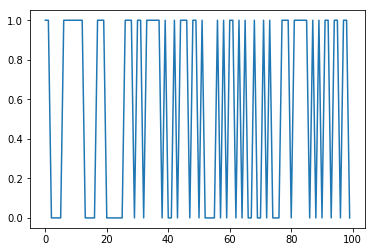

In [32]:
plt.plot(x[0], time_series[0])

In [33]:
nfft=1<<(time_series.shape[1]-1).bit_length()

In [34]:
nfft

128

In [80]:
y=np.fft.fft(time_series[0], n=nfft)
y=abs(y**2)
y=(y-y.min())
y=y/y.max()

freq_range=np.linspace(0,nfft/2,nfft/2)*1/nfft

#s, p  = sts.kstest(y[1:int(nfft/2)], 'uniform')

#y=(y-y.min())
#y=y/y.max()

In [84]:
(1/freq_range)[::-1]

array([  2.        ,   2.03225806,   2.06557377,   2.1       ,
         2.13559322,   2.17241379,   2.21052632,   2.25      ,
         2.29090909,   2.33333333,   2.37735849,   2.42307692,
         2.47058824,   2.52      ,   2.57142857,   2.625     ,
         2.68085106,   2.73913043,   2.8       ,   2.86363636,
         2.93023256,   3.        ,   3.07317073,   3.15      ,
         3.23076923,   3.31578947,   3.40540541,   3.5       ,
         3.6       ,   3.70588235,   3.81818182,   3.9375    ,
         4.06451613,   4.2       ,   4.34482759,   4.5       ,
         4.66666667,   4.84615385,   5.04      ,   5.25      ,
         5.47826087,   5.72727273,   6.        ,   6.3       ,
         6.63157895,   7.        ,   7.41176471,   7.875     ,
         8.4       ,   9.        ,   9.69230769,  10.5       ,
        11.45454545,  12.6       ,  14.        ,  15.75      ,
        18.        ,  21.        ,  25.2       ,  31.5       ,
        42.        ,  63.        , 126.        ,       

In [36]:
np.argmax(y)/nfft

0.0

In [37]:
y=np.array(y)
y=y.reshape(1,-1)

In [39]:
from sklearn.linear_model import LinearRegression

In [67]:
new_x = np.array(range(0,y.shape[1])).reshape(1,-1)

freq_range=(np.linspace(nfft/2,nfft,int(nfft/2)) *1/float(nfft))
freq_range=1/freq_range

In [68]:
1/freq_range

array([0.5       , 0.50793651, 0.51587302, 0.52380952, 0.53174603,
       0.53968254, 0.54761905, 0.55555556, 0.56349206, 0.57142857,
       0.57936508, 0.58730159, 0.5952381 , 0.6031746 , 0.61111111,
       0.61904762, 0.62698413, 0.63492063, 0.64285714, 0.65079365,
       0.65873016, 0.66666667, 0.67460317, 0.68253968, 0.69047619,
       0.6984127 , 0.70634921, 0.71428571, 0.72222222, 0.73015873,
       0.73809524, 0.74603175, 0.75396825, 0.76190476, 0.76984127,
       0.77777778, 0.78571429, 0.79365079, 0.8015873 , 0.80952381,
       0.81746032, 0.82539683, 0.83333333, 0.84126984, 0.84920635,
       0.85714286, 0.86507937, 0.87301587, 0.88095238, 0.88888889,
       0.8968254 , 0.9047619 , 0.91269841, 0.92063492, 0.92857143,
       0.93650794, 0.94444444, 0.95238095, 0.96031746, 0.96825397,
       0.97619048, 0.98412698, 0.99206349, 1.        ])

In [69]:
freq_range.shape

(64,)

In [76]:
y=y[0][int(nfft/2):]

In [41]:
new_x.shape

(1, 128)

In [77]:
mdl=LinearRegression()
mdl.fit(freq_range.reshape(1,-1).T, y.reshape(1,-1).T)
#mdl.fit(np.array(range(0,y.shape[0])[0:int(nfft/2)]).reshape(1,-1).T, np.array(range(0,y.shape[0])[0:int(nfft/2)]).reshape(1,-1).T*2 )
mdl.coef_

array([[-0.0084519]])

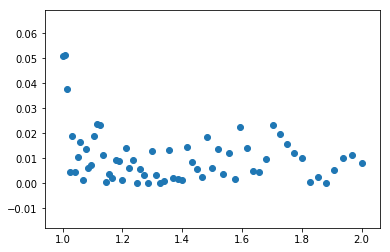

In [78]:
#plt.bar(range(0,y.shape[1])[1:16], y[0][1:16], width=0.5)
plt.scatter(freq_range, y)

In [317]:
y[0][1:16].mean()

0.035709128189077316

C:\Users\FNasiri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\FNasiri\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\transforms.py:443: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


<BarContainer object of 16 artists>

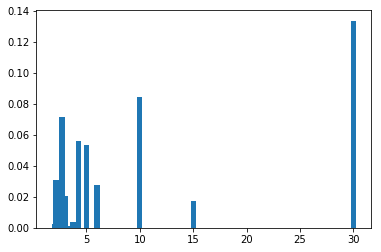

In [315]:
plt.bar(1/freq_range, y[0][0:int(nfft/2)], width=0.5)
#plt.xlim((0,64))
#plt.ylim((0,200))

In [232]:
type(y)

numpy.ndarray

In [246]:
y[0][1:].std()

0.03425641566512311

In [247]:
y[0][1:].mean()

0.03544676393282001

In [156]:
y.max()

1.0

In [260]:
y

array([8.95664293e-05, 5.28435279e-01, 1.19418827e+00, 7.43812562e-01,
       1.80361093e-04, 1.61597332e+00, 6.90634196e+00, 1.35423966e+01,
       1.43997930e+02, 1.27374627e+01, 6.74964180e+00, 1.62377512e+00,
       1.84885471e-04, 7.02704619e-01, 1.14878291e+00, 5.11141771e-01,
       9.30565054e-05, 5.11141771e-01, 1.14878291e+00, 7.02704619e-01,
       1.84885471e-04, 1.62377512e+00, 6.74964180e+00, 1.27374627e+01,
       1.43997930e+02, 1.35423966e+01, 6.90634196e+00, 1.61597332e+00,
       1.80361093e-04, 7.43812562e-01, 1.19418827e+00, 5.28435279e-01])

C:\Users\FNasiri\AppData\Local\Continuum\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


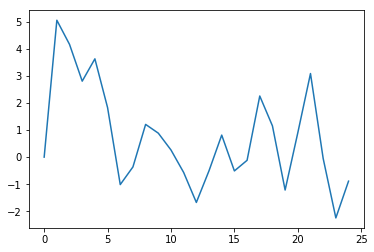

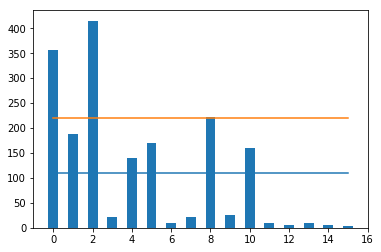

In [440]:
x=np.arange(0,25)
x=np.sin(2*3.14*0.25*x)+np.sin(2*3.14*0.125*x) + \
  np.sin(2*3.14*0.0625*x)+np.sin(2*3.14*0.15*x)+ \
  np.sin(2*3.14*0.03*x)+np.sin(2*3.14*0.07*x)+ \
  np.sin(2*3.14*0.3*x)+np.sin(2*3.14*0.4*x)+ \
  np.sin(2*3.14*0.1*x)+np.sin(2*3.14*0.6*x)
nfft=1<<(len(x)-1).bit_length()
y=np.fft.fft(x, n=nfft)
y=abs(y**2)
#y=(y-y.min())
#y=y/y.max()

sss=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]



plt.figure(1)
plt.plot(np.arange(0,25), x)


plt.figure(2)
plt.bar(range(0,len(y))[0:16], y[0:16], width=0.5)
plt.plot(range(0,len(y))[0:16], np.array(sss[0:16])*(y[0:16].mean())  )
plt.plot(range(0,len(y))[0:16], 2*np.array(sss[0:16])*(y[0:16].mean())  )

In [441]:
y[0:16].std()

128.85572856005354

In [442]:
y[0:16].mean()

110.0370211491407

In [443]:
y[0:16].std()/y[0:16].mean()

1.1710215999523157

In [444]:
mdl=LinearRegression()
mdl.fit(np.array(range(0,y.shape[0])[0:int(nfft/2)]).reshape(1,-1).T, np.array(y[0:int(nfft/2)]).reshape(1,-1).T)
#mdl.fit(np.array(range(0,y.shape[0])[0:int(nfft/2)]).reshape(1,-1).T, np.array(range(0,y.shape[0])[0:int(nfft/2)]).reshape(1,-1).T*2 )
mdl.coef_

array([[-19.07253709]])

In [109]:
bb=np.array([[1,2,3,4]])

In [111]:
bb=bb.T

In [110]:
bb.shape


(1, 4)

In [112]:
print(np.argmax(bb, axis=0))

[3]
